Projekt Wizualizacja Danych: Gry Komputerowe, Platforma Steam

Biblioteki:

In [77]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib.lines import Line2D

Pobranie danych ze strony steamspy dla top 100 gier forever w celu ustalenia 5 najbardziej popularnych gatunków gier na platformie Steam

In [78]:
# Pobieranie danych z API
url = 'https://steamspy.com/api.php?request=top100forever'
response = requests.get(url)
data = response.json()

# Tworzenie słownika gatunków gier
genres_count = {}

# Wyłuskiwanie informacji dla każdego appid
for index, (appid, game_data) in enumerate(data.items(), start=1):
    url = f"https://steamspy.com/api.php?request=appdetails&appid={appid}"
    response = requests.get(url)
    if response.status_code == 200:
        game_info = response.json()
        print(f"Przeszukiwanie {index}/{len(data)} - Pobrano informacje o appid: {appid}")
        genres = game_info.get('genre', '').split(', ')
        for genre in genres:
            genres_count[genre] = genres_count.get(genre, 0) + 1
    else:
        print(f"Nie udało się pobrać informacji dla appid {appid}")

# Sortowanie gatunków wg liczby gier
top_genres = sorted(genres_count.items(), key=lambda x: x[1], reverse=True)

# Wyświetlanie top 5 gatunków
print("Top 5 najczęściej występujących gatunków:")
for index, (genre, count) in enumerate(top_genres[:5], start=1):
    print(f"{index}. {genre}: {count}")


Przeszukiwanie 1/100 - Pobrano informacje o appid: 570
Przeszukiwanie 2/100 - Pobrano informacje o appid: 730
Przeszukiwanie 3/100 - Pobrano informacje o appid: 578080
Przeszukiwanie 4/100 - Pobrano informacje o appid: 1063730
Przeszukiwanie 5/100 - Pobrano informacje o appid: 1623730
Przeszukiwanie 6/100 - Pobrano informacje o appid: 440
Przeszukiwanie 7/100 - Pobrano informacje o appid: 1172470
Przeszukiwanie 8/100 - Pobrano informacje o appid: 1938090
Przeszukiwanie 9/100 - Pobrano informacje o appid: 271590
Przeszukiwanie 10/100 - Pobrano informacje o appid: 550
Przeszukiwanie 11/100 - Pobrano informacje o appid: 1599340
Przeszukiwanie 12/100 - Pobrano informacje o appid: 252490
Przeszukiwanie 13/100 - Pobrano informacje o appid: 304930
Przeszukiwanie 14/100 - Pobrano informacje o appid: 553850
Przeszukiwanie 15/100 - Pobrano informacje o appid: 230410
Przeszukiwanie 16/100 - Pobrano informacje o appid: 236390
Przeszukiwanie 17/100 - Pobrano informacje o appid: 1245620
Przeszukiwan

Dalsze wyłuskiwanie danych. Dla top 5 gatunków poniżej uzyskuje dane dla najpopularniejszej gry w danym garunku pod względem graczy oraz dla uśrednionej wartości top 100 gier. Wyłuskiwane dane to np. liczba pozytywnych i negatywnych recenzji oraz utworzenie dla nich proporcji, zliczanie publisherów oraz developerów, następnie pokazanie liczby graczy oraz cen w przedziałach.

In [79]:
# Inicjalizacja kontenerów dla danych
genre_data = {}
average_positive_to_negative_ratio = {}

# Pobieranie danych z API
for genre in top_genres[:5]:
    genre_name = genre[0].replace(" ", "+")
    print(f"{genre_name}")
    url = f'https://steamspy.com/api.php?request=genre&genre={genre_name}'
    response = requests.get(url)
    data = response.json()

    # Przechowywanie danych dla danego genre_name
    genre_info = []
    developers = []
    publishers = []
    positive_reviews_total = 0
    negative_reviews_total = 0
    owners_counter = Counter()
    price_counter = Counter()

    total_games_used = 0  # Liczba gier użytych do utworzenia uśrednionego zestawienia

    highest_price_game = None
    lowest_price_game = None
    highest_price = float('-inf')
    lowest_price = float('inf')

    for index, (appid, info) in enumerate(data.items()):
        # Uśrednianie danych dla wszystkich gier
        developers.append(info["developer"])
        publishers.append(info["publisher"])
        positive_reviews_total += info["positive"]
        negative_reviews_total += info["negative"]
        owners_counter.update([info["owners"]])
        price_counter.update([info["price"]])
        total_games_used += 1

        # Sprawdzenie najdroższej i najtańszej gry
        price = float(info["price"])
        if price > highest_price:
            highest_price = price
            highest_price_game = {
                "name": info["name"],
                "price": info["price"]
            }
        if price < lowest_price:
            lowest_price = price
            lowest_price_game = {
                "name": info["name"],
                "price": info["price"]
            }

        if index == 0:
            # Najpopularniejsza gra w danym genre
            most_popular_game = {
                "name": info["name"],
                "developer": info["developer"],
                "publisher": info["publisher"],
                "positive_reviews": info["positive"],
                "negative_reviews": info["negative"],
                "owners": info["owners"],
                "price": info["price"]
            }

    # Obliczanie proporcji pozytywnych do negatywnych recenzji
    if index > 0:
        average_positive_to_negative_ratio[genre_name] = (positive_reviews_total / negative_reviews_total)

    # Obliczanie najczęściej występującego developera i publishera
    most_common_developer = Counter(developers).most_common(1)[0]
    most_common_publisher = Counter(publishers).most_common(1)[0]

    # Obliczanie najczęściej występującej liczby właścicieli oraz ceny
    most_common_owners = owners_counter.most_common(1)[0][0]
    most_common_owners_count = owners_counter.most_common(1)[0][1]  # Liczba wystąpień najczęstszego właściciela
    most_common_price = price_counter.most_common(1)[0][0]
    most_common_price_count = price_counter.most_common(1)[0][1]  # Liczba wystąpień najczęstszej ceny

    # Dystrybucja cen gier
    price_distribution = {}
    price_ranges = [("$0 - $10", 0, 10), ("$10 - $20", 10, 20), ("$20 - $30", 20, 30), ("$30 - $40", 30, 40), ("$40 - $50", 40, 50), ("$50 - $60", 50, 60), ("$60 - $70", 60, 70), ("$70 - $80", 70, 80), ("$80 - $90", 80, 90), ("$90 - $100", 90, 100), ("> $100", 100, float('inf'))]
    for price_range in price_ranges:
        price_distribution[price_range[0]] = sum(count for price, count in price_counter.items() if price_range[1] <= float(price) < price_range[2])

    # Zapisanie danych do kontenera
    genre_data[genre_name] = {
        "most_popular_game": most_popular_game,
        "average_developer": most_common_developer[0],
        "average_publisher": most_common_publisher[0],
        "average_developer_appearances": most_common_developer[1],
        "average_publisher_appearances": most_common_publisher[1],
        "average_positive_to_negative_ratio": average_positive_to_negative_ratio.get(genre_name, 0),
        "most_common_owners": most_common_owners,
        "most_common_owners_count": most_common_owners_count,
        "most_common_price": most_common_price,
        "most_common_price_count": most_common_price_count,
        "total_games_used": total_games_used,
        "highest_price_game": highest_price_game,
        "lowest_price_game": lowest_price_game,
        "owners_distribution": owners_counter,
        "price_distribution": price_distribution
    }

# Wyświetlenie zestawienia danych dla każdego genre_name
for genre_name, data in genre_data.items():
    print(f"Zestawienie danych dla {genre_name}:")
    print(f"   Total Games Used for Averaging: {data['total_games_used']}")
    print("\n")
    print("Najpopularniejsza gra:")
    print(f"   Name: {data['most_popular_game']['name']}")
    print(f"   Developer: {data['most_popular_game']['developer']}")
    print(f"   Publisher: {data['most_popular_game']['publisher']}")
    print(f"   Positive Reviews: {data['most_popular_game']['positive_reviews']}")
    print(f"   Negative Reviews: {data['most_popular_game']['negative_reviews']}")
    print(f"   Owners: {data['most_popular_game']['owners']}")
    print(f"   Price: {data['most_popular_game']['price']}")
    print("\n")
    print("Dane uśrednione:")
    print(f"   Most Popular Developer: {data['average_developer']} (Appearances: {data['average_developer_appearances']})")
    print(f"   Most Popular Publisher: {data['average_publisher']} (Appearances: {data['average_publisher_appearances']})")
    print(f"   Average Positive to Negative Ratio: {data['average_positive_to_negative_ratio']}")
    print(f"   Most Common Owners: {data['most_common_owners']} (Count: {data['most_common_owners_count']})")
    print(f"   Most Common Price: {data['most_common_price']} (Count: {data['most_common_price_count']})")
    print(f"   Highest Price Game: {data['highest_price_game']['name']} (${data['highest_price_game']['price']})")
    print(f"   Lowest Price Game: {data['lowest_price_game']['name']} (${data['lowest_price_game']['price']})")
    print("\n")
    print("Dystrybucja liczby właścicieli:")
    for owner_range, count in data['owners_distribution'].items():
        print(f"   Owners: {owner_range}, Games: {count}")
    print("\n")
    print("Dystrybucja cen:")
    for price_range, count in data['price_distribution'].items():
        print(f"   Price Range: {price_range}, Games: {count}")
    print("\n")


Action
Adventure
Indie
Free+to+Play
RPG
Zestawienie danych dla Action:
   Total Games Used for Averaging: 31275


Najpopularniejsza gra:
   Name: Dota 2
   Developer: Valve
   Publisher: Valve
   Positive Reviews: 1833370
   Negative Reviews: 406340
   Owners: 200,000,000 .. 500,000,000
   Price: 0


Dane uśrednione:
   Most Popular Developer: Dnovel (Appearances: 48)
   Most Popular Publisher: Conglomerate 5 (Appearances: 135)
   Average Positive to Negative Ratio: 5.5763373314402624
   Most Common Owners: 0 .. 20,000 (Count: 21069)
   Most Common Price: 0 (Count: 4091)
   Highest Price Game: Ascent Free-Roaming VR Experience ($99900)
   Lowest Price Game: Dota 2 ($0)


Dystrybucja liczby właścicieli:
   Owners: 200,000,000 .. 500,000,000, Games: 1
   Owners: 100,000,000 .. 200,000,000, Games: 1
   Owners: 50,000,000 .. 100,000,000, Games: 9
   Owners: 20,000,000 .. 50,000,000, Games: 20
   Owners: 10,000,000 .. 20,000,000, Games: 35
   Owners: 5,000,000 .. 10,000,000, Games: 83
   Ow

Utworzenie zestawienia danych dla powyższego rezultatu

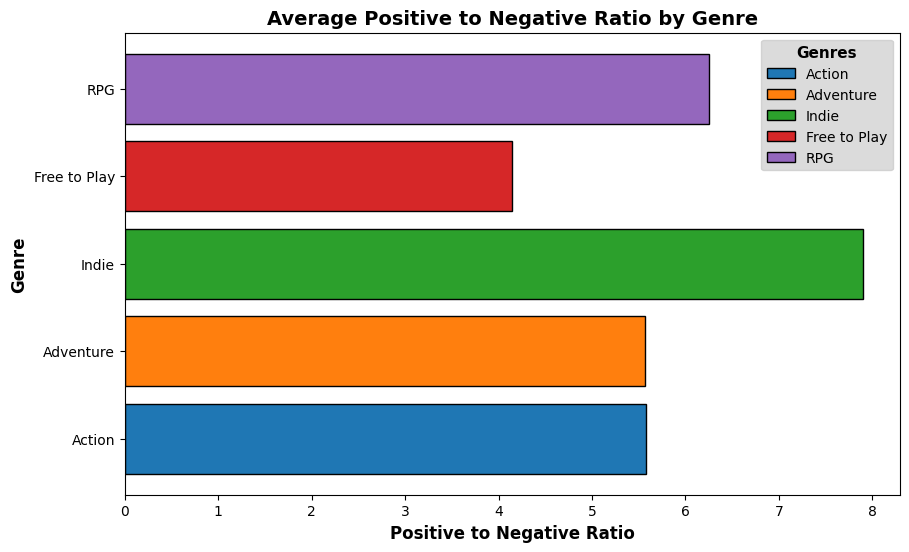

In [80]:
# Inicjalizacja list dla proporcji pozytywnych do negatywnych recenzji i gatunków
ratios = []
genres = []

# Przechodzenie przez dane i dodawanie do list
for genre_name, data in genre_data.items():
    ratios.append(data['average_positive_to_negative_ratio'])
    genres.append(genre_name.replace("+", " "))

# Tworzenie wykresu słupkowego poziomego
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(range(len(ratios)))  # Zróżnicowanie kolorów
bars = plt.barh(genres, ratios, color=colors, edgecolor='black')  # Dodanie obramowania

# Etykieta osi i tytuł wykresu
plt.xlabel('Positive to Negative Ratio', fontsize=12, fontweight='bold')
plt.ylabel('Genre', fontsize=12, fontweight='bold')
plt.title('Average Positive to Negative Ratio by Genre', fontsize=14, fontweight='bold')

# Dodanie legendy z tłem
for bar, genre in zip(bars, genres):
    bar.set_label(genre)
legend = plt.legend(title='Genres', fontsize=10, loc='upper right', frameon=True, facecolor='lightgray')
plt.setp(legend.get_title(), fontsize=11, fontweight='bold')

# Wyświetlenie wykresu
plt.show()

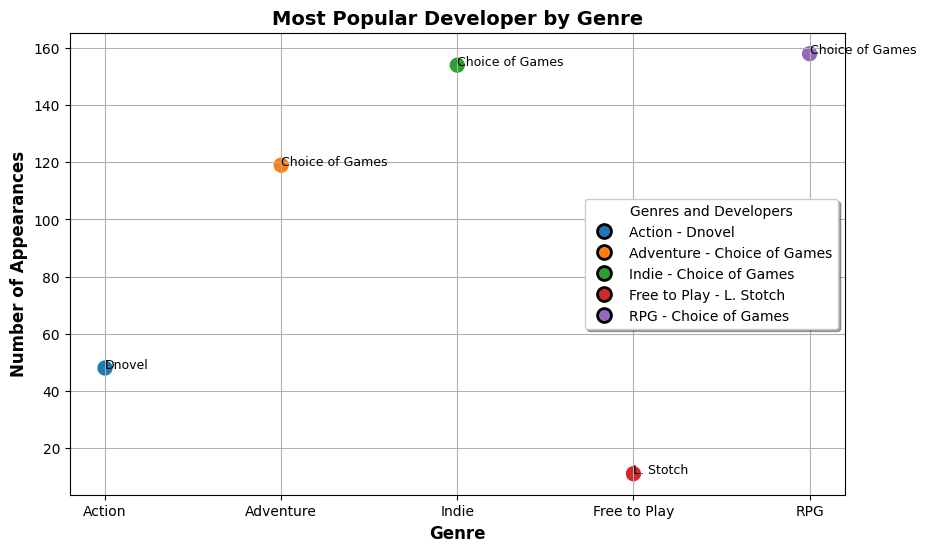

In [81]:
# Inicjalizacja list dla deweloperów i liczby wystąpień
developers = []
appearances = []
genres = []

# Przechodzenie przez dane i dodawanie do list
for genre_name, data in genre_data.items():
    developers.append(data['average_developer'])
    appearances.append(data['average_developer_appearances'])
    genres.append(genre_name.replace("+", " "))

# Tworzenie wykresu chmury punktów
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(range(len(developers)))  # Zróżnicowanie kolorów
scatter = plt.scatter(genres, appearances, c=colors, s=100)

# Dodanie siatki
plt.grid(True)

# Dodanie etykiet do punktów
for i, txt in enumerate(developers):
    plt.annotate(txt, (genres[i], appearances[i]), fontsize=9)

# Tworzenie niestandardowej legendy
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'{genres[i]} - {developers[i]}',
                          markerfacecolor=colors[i], markersize=10, markeredgewidth=2, markeredgecolor='black') for i in range(len(developers))]

# Dodanie legendy w po prawej stronie z tłem
plt.legend(handles=legend_elements, loc='right', title='Genres and Developers', fancybox=True, shadow=True)

# Etykiety osi i tytuł wykresu
plt.xlabel('Genre', fontsize=12, fontweight='bold')
plt.ylabel('Number of Appearances', fontsize=12, fontweight='bold')
plt.title('Most Popular Developer by Genre', fontsize=14, fontweight='bold')

# Wyświetlenie wykresu
plt.show()

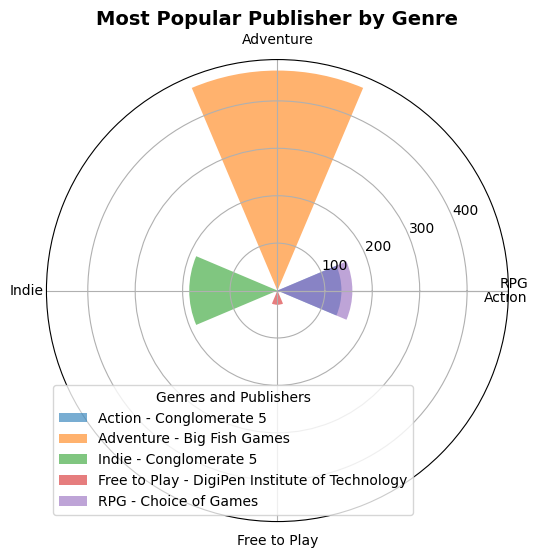

In [82]:
# Inicjalizacja list dla wydawców i liczby wystąpień
publishers = []
appearances = []
genres = []

# Przechodzenie przez dane i dodawanie do list
for genre_name, data in genre_data.items():
    publishers.append(data['average_publisher'])
    appearances.append(data['average_publisher_appearances'])
    genres.append(genre_name.replace("+", " "))

# Tworzenie wykresu biegunowego
theta = np.linspace(0, 2 * np.pi, len(publishers))
radii = appearances
colors = plt.cm.tab10(range(len(publishers)))  # Zróżnicowanie kolorów

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, color=colors, alpha=0.6)

# Dodanie etykiet do wykresu
ax.set_xticks(theta)
ax.set_xticklabels(genres)

# Przesunięcie etykiet dla czytelności
for i, label in enumerate(ax.get_xticklabels()):
    if genres[i] == "Action":
        label.set_verticalalignment('top')  # Zmiana położenia pionowego dla "Action"
        label.set_horizontalalignment('right')
    elif genres[i] == "RPG":
        label.set_verticalalignment('bottom') # Zmiana położenia pionowego dla "RPG"
        label.set_horizontalalignment('right')

# Etykieta osi i tytuł wykresu
plt.title('Most Popular Publisher by Genre', fontsize=14, fontweight='bold')

# Dodanie legendy
legend_labels = [f'{genres[i]} - {publishers[i]}' for i in range(len(publishers))]
ax.legend(bars, legend_labels, title='Genres and Publishers')

# Wyświetlenie wykresu
plt.show()

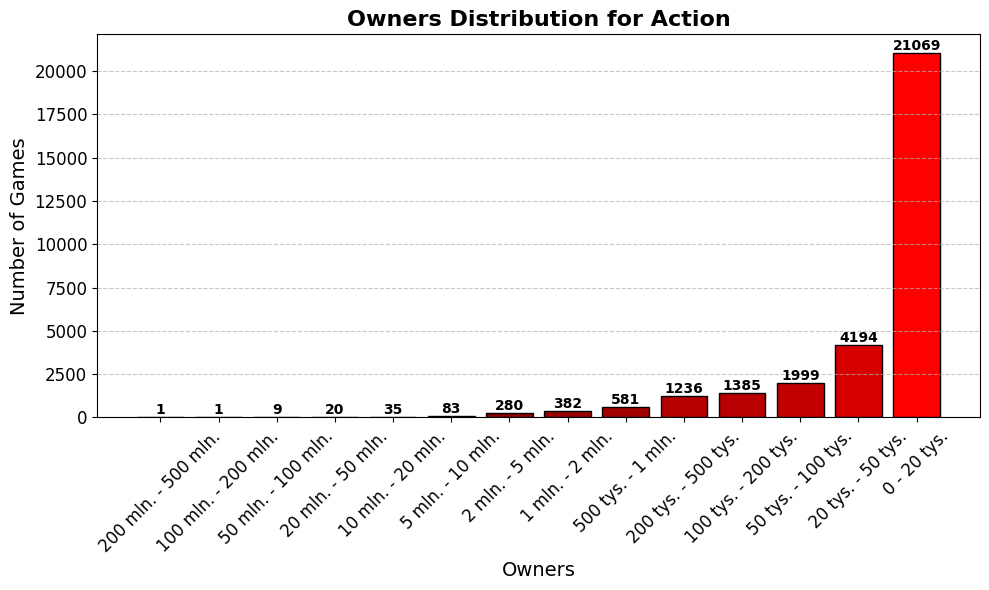

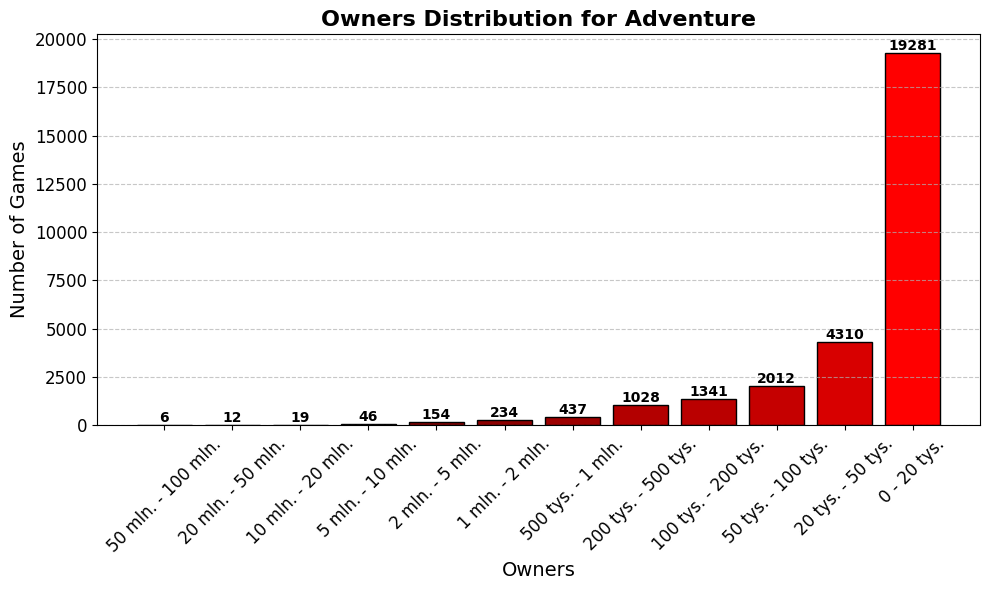

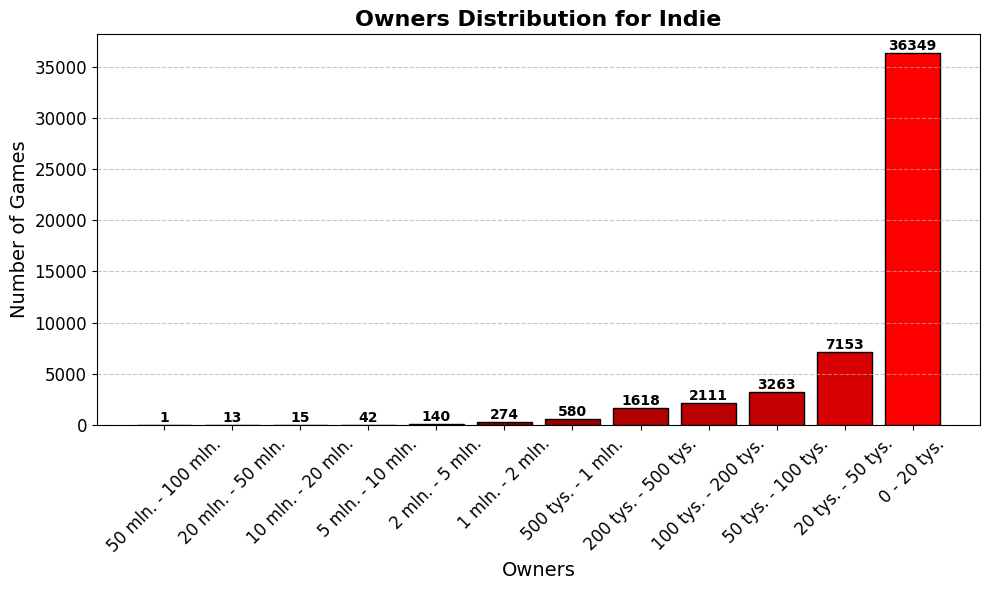

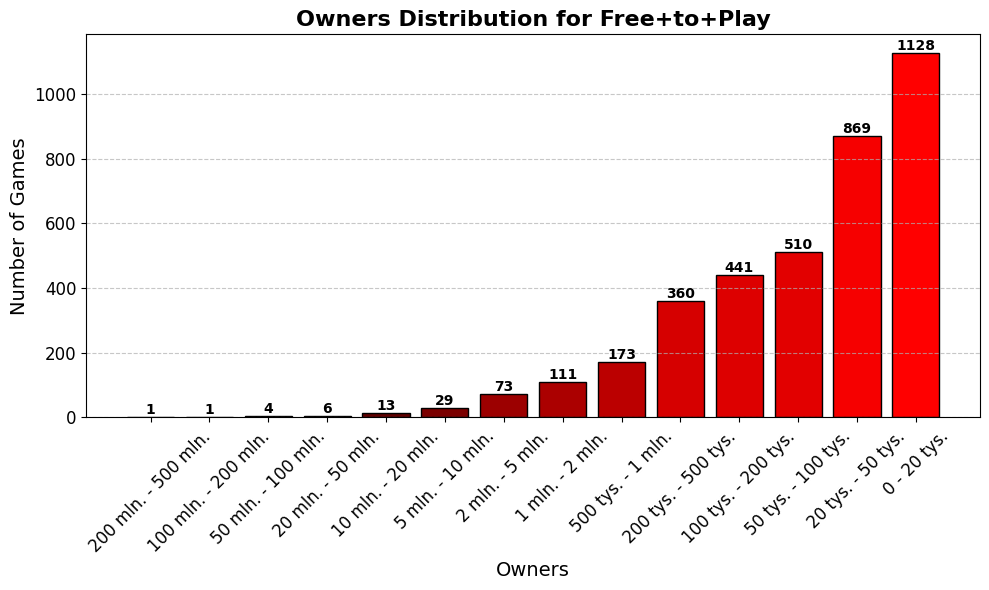

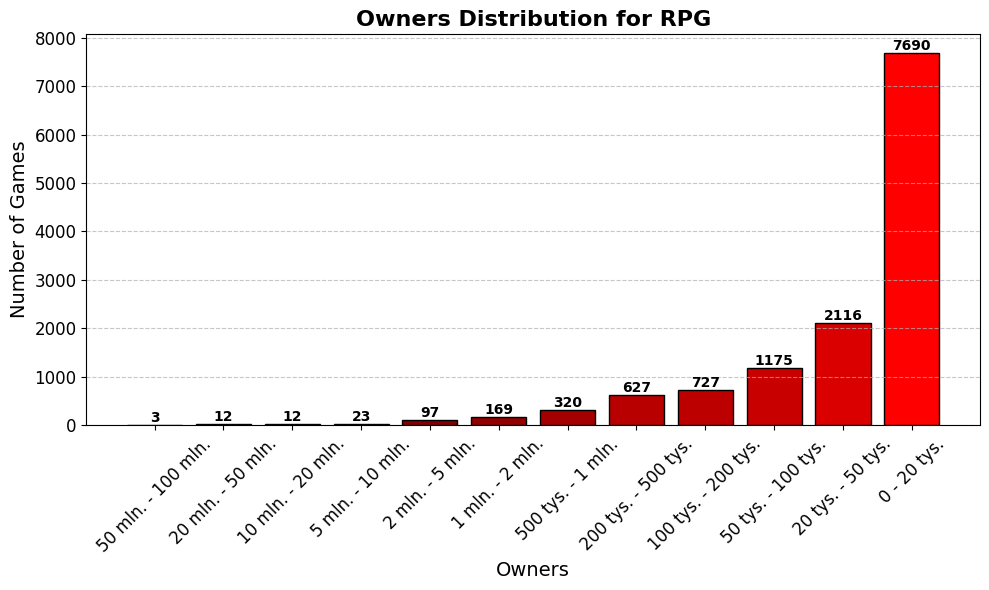

In [83]:
# Funkcja do generowania wykresu słupkowego z gradientem czerwieni
def generate_bar_chart_red_gradient(data, title, xlabel, ylabel, isGCA):
    labels = list(data.keys())
    values = list(data.values())

    # Obliczenie kolorów w gradientzie czerwieni w zależności od wartości danych
    max_value = max(values)
    log_values = [np.log10(value + 1) for value in values]  # Logarytmiczna transformacja wartości
    colors = [(np.log10(value + 1) / np.log10(max_value + 1), 0, 0) for value in values]  # Zastosowanie logarytmicznej skali czerwieni

    # Tworzenie wykresu słupkowego
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=colors, edgecolor='black')

    # Dodanie wartości nad słupkami
    for bar in bars:
        yval = bar.get_height()
        xpos = bar.get_x() + bar.get_width() / 2
        plt.text(xpos, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.xticks(np.arange(len(labels)), labels) # Ustawienie etykiet zamiast ticków
    if (isGCA):
        plt.gca().set_xticklabels(['0 - 20 tys.', '20 tys. - 50 tys.', '50 tys. - 100 tys.', '100 tys. - 200 tys.', '200 tys. - 500 tys.', '500 tys. - 1 mln.', '1 mln. - 2 mln.', '2 mln. - 5 mln.', '5 mln. - 10 mln.', '10 mln. - 20 mln.', '20 mln. - 50 mln.', '50 mln. - 100 mln.', '100 mln. - 200 mln.', '200 mln. - 500 mln.'][::-1]) # Zmiana etykiet
    else:
        plt.gca().set_xticklabels(['0 - 20 tys.', '20 tys. - 50 tys.', '50 tys. - 100 tys.', '100 tys. - 200 tys.', '200 tys. - 500 tys.', '500 tys. - 1 mln.', '1 mln. - 2 mln.', '2 mln. - 5 mln.', '5 mln. - 10 mln.', '10 mln. - 20 mln.', '20 mln. - 50 mln.', '50 mln. - 100 mln.'][::-1]) # Zmiana etykiet
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Dystrybucja liczby właścicieli dla każdego gatunku gier
for indeks, (genre_name, data) in enumerate(genre_data.items()):
  if (indeks == 1 or indeks == 2 or indeks == 4):
    generate_bar_chart_red_gradient(data['owners_distribution'], f'Owners Distribution for {genre_name}', 'Owners', 'Number of Games', False)
  else:
    generate_bar_chart_red_gradient(data['owners_distribution'], f'Owners Distribution for {genre_name}', 'Owners', 'Number of Games', True)


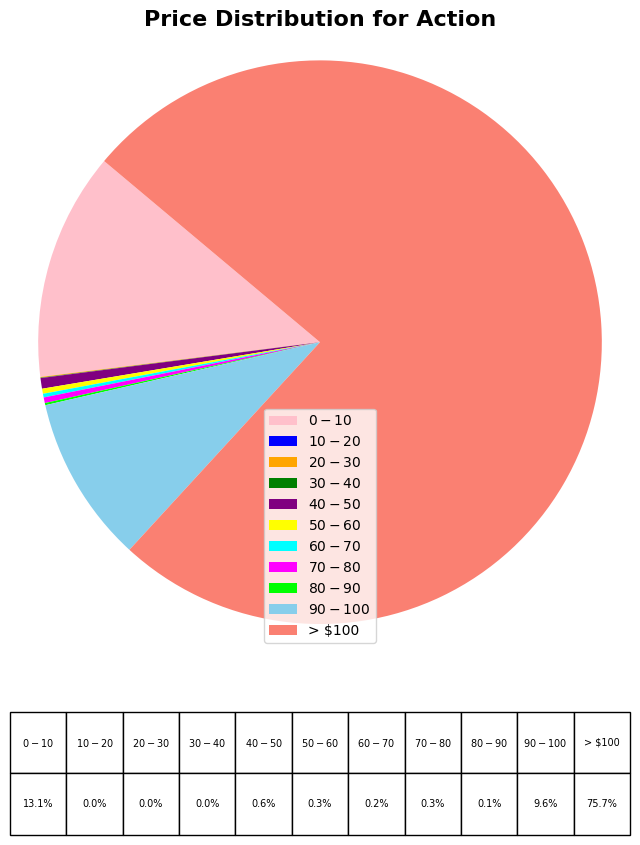

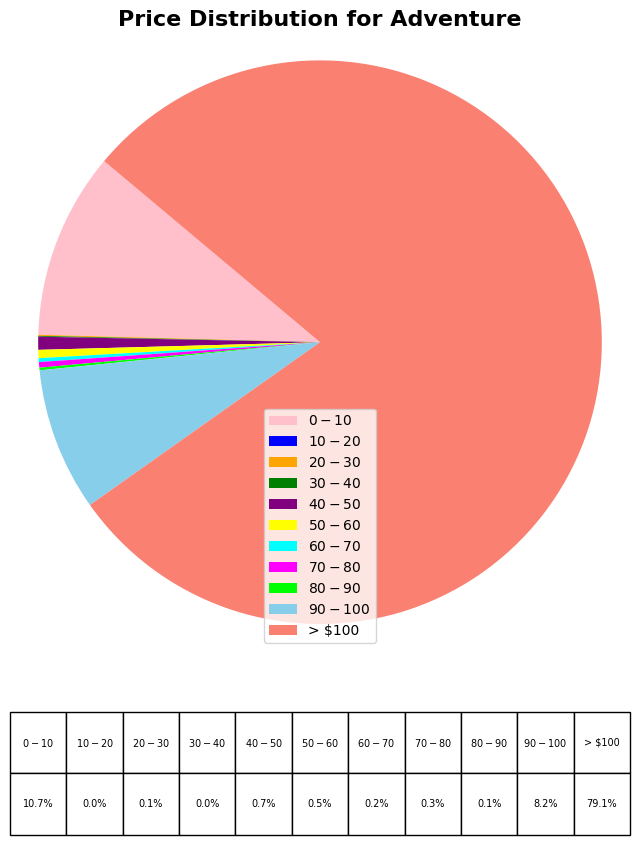

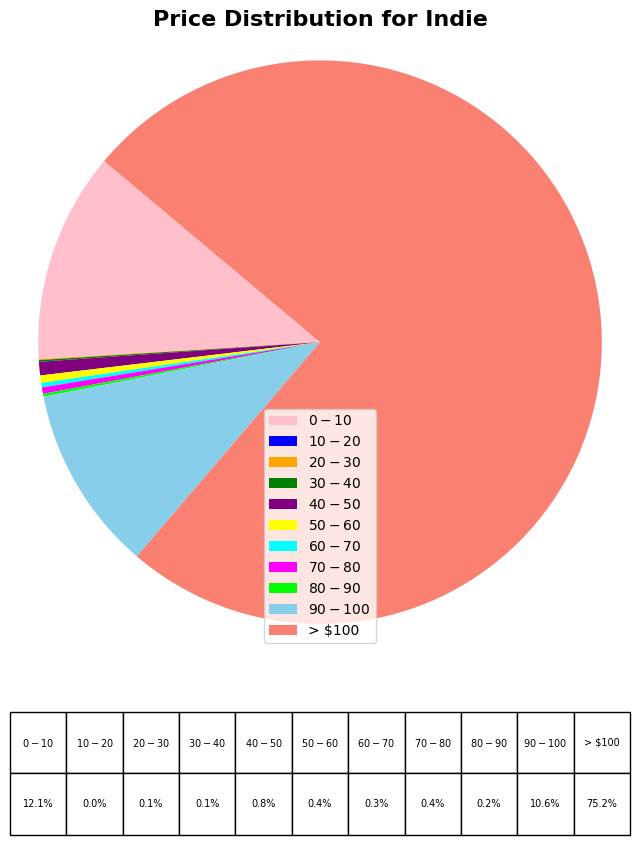

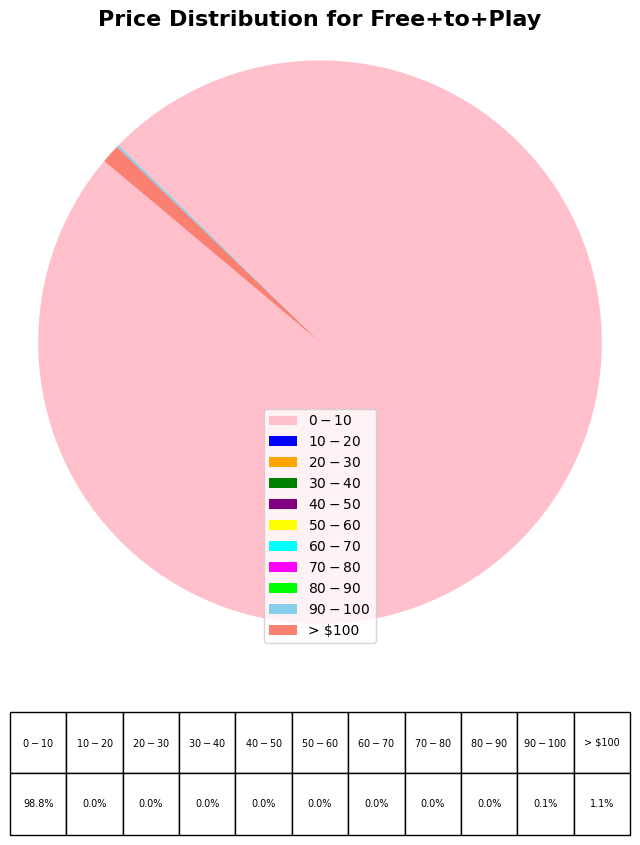

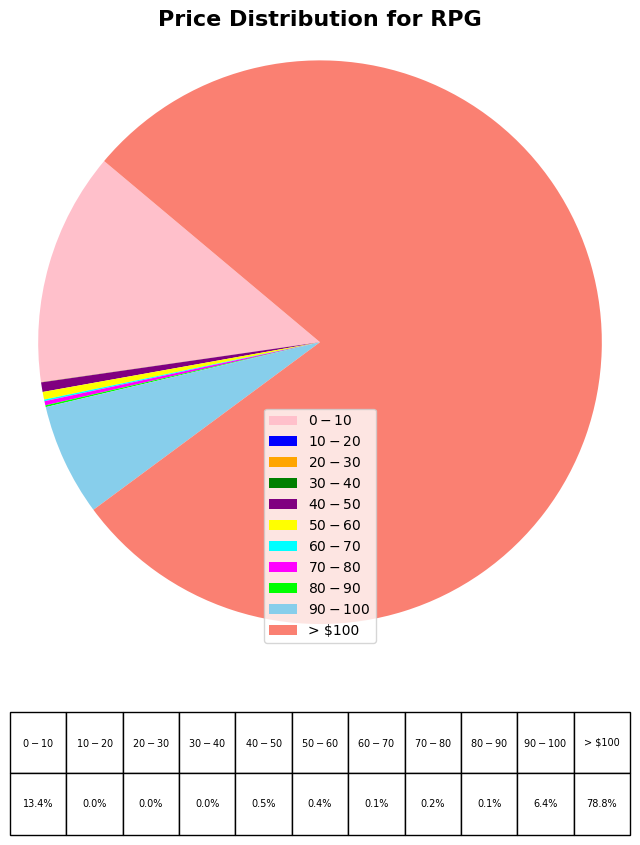

In [84]:
# Funkcja do generowania spersonalizowanego wykresu kołowego z wartościami bezwzględnymi
def generate_personalized_pie_chart_absolute(data, title):
    labels = list(data.keys())
    values = list(data.values())

    # Zdefiniowanie listy kolorów
    colors = ['pink', 'blue', 'orange', 'green', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'skyblue', 'salmon', 'gold', 'teal']

    plt.figure(figsize=(8, 8))
    patches, _ = plt.pie(values, labels=[''] * len(labels), startangle=140, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
    plt.legend(patches, labels, loc="best")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('equal')  # Ustawienie wykresu na koło

    # Dodanie tabeli z wartościami procentowymi
    plt.table(cellText=[[f'{val / sum(values) * 100:.1f}%' for val in values]], colLabels=labels, cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])

    plt.show()

# Dystrybucja cen dla każdego gatunku gier
for genre_name, data in genre_data.items():
    generate_personalized_pie_chart_absolute(data['price_distribution'], f'Price Distribution for {genre_name}')